In [1]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter6=True)



fatal: destination path 'notebooks' already exists and is not an empty directory.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
#!pip install tokenizers==0.13.3


In [3]:
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v2.0.0


In [4]:
from transformers import pipeline, set_seed, AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric

from tqdm import tqdm
import torch


In [5]:
import numpy

In [6]:
!pip install -U nltk

import nltk

nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize



  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9
    Uninstalling nltk-3.9:
      Successfully uninstalled nltk-3.9


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Loading The SamSum Dataset


In [7]:
from datasets import load_dataset

dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]



  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [9]:
summaries = {}
sample = dataset_samsum["train"][1]
sample_text = dataset_samsum["train"][1]["dialogue"][:2000]


In [10]:
#Summarizartion Baseline
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

#Pegasus
**Loading Pegasus**
We use pegasus model pretrained on the cnn_dailymail dataset, so we will be evaluatuing Pegasus on the CNN/DailyMail dataset, and then we will fine tune it for SamSum dataset

In [11]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .", ".\n")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map

# ROUGE
ROUGE stands for Recall-Oriented Understudy for
Gisting Evaluation. It includes measures to automatically determine the quality of a summary by comparing it to other (ideal) summaries created by
humans.

Ref: https://aclanthology.org/W04-1013.pdf

We will use it as a metric for evaluating the summaries Pegasus create and also we will use it to compare it to other SOTA in text summarization

In [12]:
rouge_metric = load_metric("rouge")


In [13]:
reference  = dataset_samsum["test"][1]["summary"]

records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]



# Summaries Evaluation
In this section, we create the methods necessary for summary evaluation.

evaluate_summaries_pegasus is function which

In [14]:
def evaluate_summaries_baseline(dataset, metric, column_text, column_summary):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score


In [15]:
test_sampled = dataset_samsum["test"].shuffle(seed=42).select(range(818))

score = evaluate_summaries_baseline(test_sampled, rouge_metric, "dialogue", "summary")
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.297174,0.086012,0.229379,0.26679


In [16]:

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=16, device=device, column_text="dialogue", column_summary="summary"):
    dialogue_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for dialogue_batch, target_batch in tqdm(
        zip(dialogue_batches, target_batches), total=len(dialogue_batches)):

        inputs = tokenizer(dialogue_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score


In [17]:

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015551,0.000301,0.01553,0.015546


# Pegasus fine-tuning for the SamSum dataset

In [18]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])


Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [19]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .", ".\n"))

Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
<n>Hannah: I'd rather you texted him.
<n>Amanda: Just text him.



In [20]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [18:32<00:00, 10.80s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015543,0.000299,0.01556,0.015584


In [21]:
pd.DataFrame(rouge_dict, index=["pegasus"])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015543,0.000299,0.01556,0.015584


**FINE TUNING**

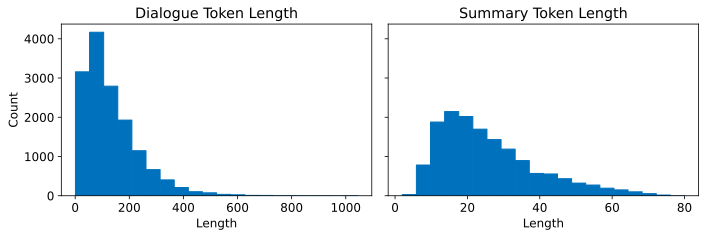

In [22]:

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [23]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [24]:
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'abstract','summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",abstract
7,"[PAD, Transformers, are, awesome, for, text, a...",summarization


In [25]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [37]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [38]:
from huggingface_hub import notebook_login

notebook_login()

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["validation"],
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/notebooks/pegasus-samsum is already a clone of https://huggingface.co/ch4m3l1on/pegasus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.


In [29]:
#!pip3 install numpy==1.23.5


In [ ]:
trainer.train()
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, trainer.model, tokenizer, batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: id, dialogue, summary.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


In [31]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018523,0.000311,0.018427,0.018462


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rouge1']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rouge1'}, axis=1)
              .sort_values('rouge1', ascending=True))
  xs = counted['rouge1']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('rouge1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rouge1')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rouge2']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rouge2'}, axis=1)
              .sort_values('rouge2', ascending=True))
  xs = counted['rouge2']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('rouge2', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rouge2')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rougeL']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rougeL'}, axis=1)
              .sort_values('rougeL', ascending=True))
  xs = counted['rougeL']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('rougeL', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rougeL')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rougeLsum']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rougeLsum'}, axis=1)
              .sort_values('rougeLsum', ascending=True))
  xs = counted['rougeLsum']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('rougeLsum', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rougeLsum')
_ = plt.ylabel('count()')

# Testing the fine tuned Pegasus

In [32]:
import transformers
transformers.logging.set_verbosity_error()

In [36]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry instead of calling Betty.
